In [4]:
import numpy as np
import umap
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp
import segypy
from scipy.interpolate import interp2d
%load_ext autoreload
%autoreload 2
from utils import load_seismic, load_horizon, colorbar, interpolate_horizon, plot_section_horizon_and_well
from utils import flatten_on_horizon

## Loading the seismic near and far offset amplitude data from the segy files

In [28]:
near_stack_amplitudes, twt = load_seismic('./data/3d_nearstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])
far_stack_amplitudes, twt = load_seismic('./data/3d_farstack.sgy', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

SegyPY0.57:  readSegy : Trying to read ./data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ./data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ./data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


## Loading and interpolating the picked horizon data

In [20]:
horizon = load_horizon('./data/Top_Heimdal_subset.txt', inlines=[1300, 1502, 2], xlines=[1500, 2002, 2])

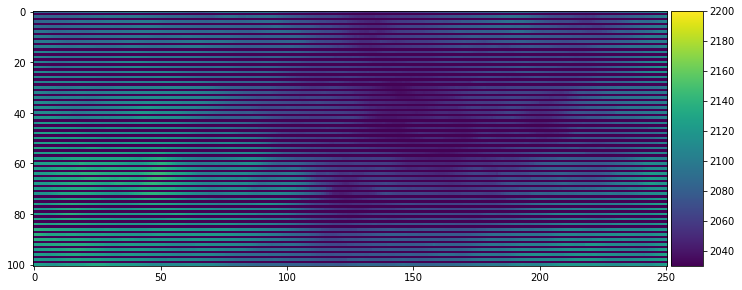

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(horizon, vmin=2030, vmax=2200)
colorbar(ax1)

In [24]:
interpolated_horizon = interpolate_horizon(horizon)

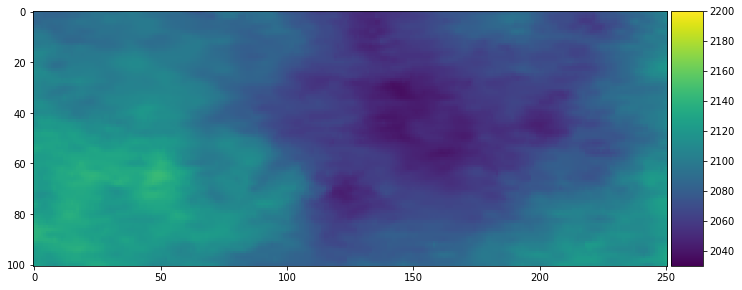

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(interpolated_horizon, vmin=2030, vmax=2200)
colorbar(ax1)

## Plotting the amplitude data with the horizon and the well as in Per's Book

In [35]:
well_i, well_x = 36, 276//2

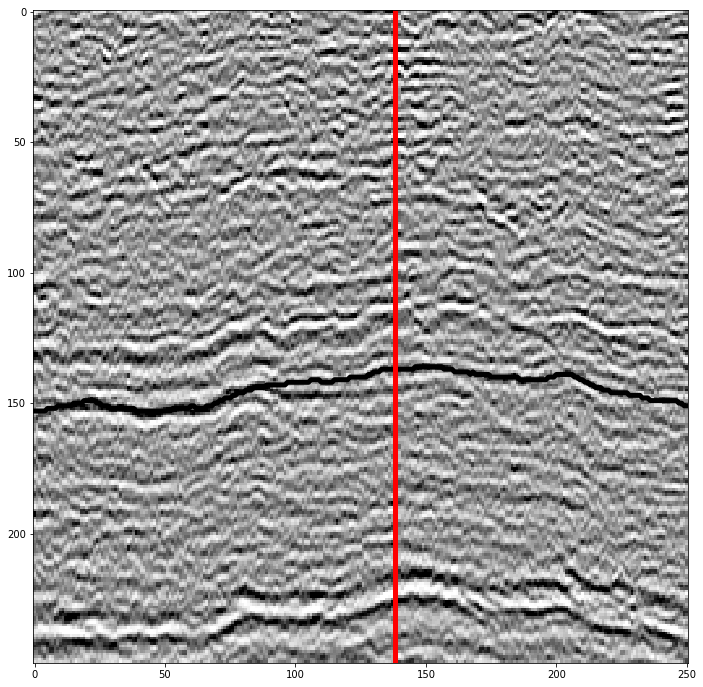

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_section_horizon_and_well(ax, near_stack_amplitudes, horizon, twt, inline=well_i, well_pos=well_x)

## Flatten the traces on the horizon and select 64 samples around the horizon

In [37]:
near_traces = flatten_on_horizon(near_stack_amplitudes, horizon, twt, top_add=12, below_add=52)
far_traces = flatten_on_horizon(far_stack_amplitudes, horizon, twt, top_add=12, below_add=52)

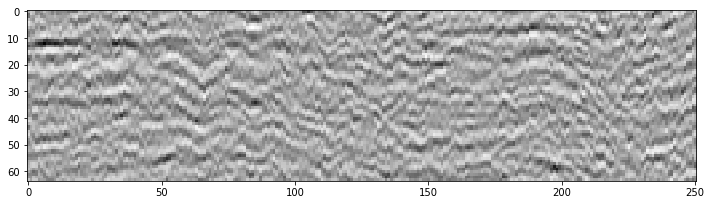

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(near_traces[0].T, cmap="Greys")

In [39]:
#np.save("near_traces_64.npy", near_traces)
#np.save("far_traces_64.npy", far_traces)

## Unsupervised Cluster Analysis of Glitne Near-Far Offset Data and Fluid Factor

The aim of this notebook is to analyse the Glitne Near-Far Offset Data using unsupervised dimensionality reduction methods and to evaluate the presence of clusters within the data.  
These clusters may be linked to the present hydrocarbon anomaly in the Glitne dataset.

### Data Loading

We've already previously converted the near and far offset traces from segy to a numpy array for easier handling of the data. The data shown has been flattened on the horizon of the heimdahl.

The well position of well-15-5 is 38/138 in this frame of reference.

We normalize the whole dataset using a 3x3 grid around the well.  
Near and Far offset data are normalised seperately.

In [20]:
near_traces = np.load("./near_traces_64.npy")
far_traces =  np.load("./far_traces_64.npy")

well_i, well_x = 38, 138

well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

near_traces /= well_variance_near
far_traces /= well_variance_far

near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb = far_traces.reshape(-1, 64)

### Plotting the normalised near and far offset traces respectively

Text(0.5, 1.0, 'Far')

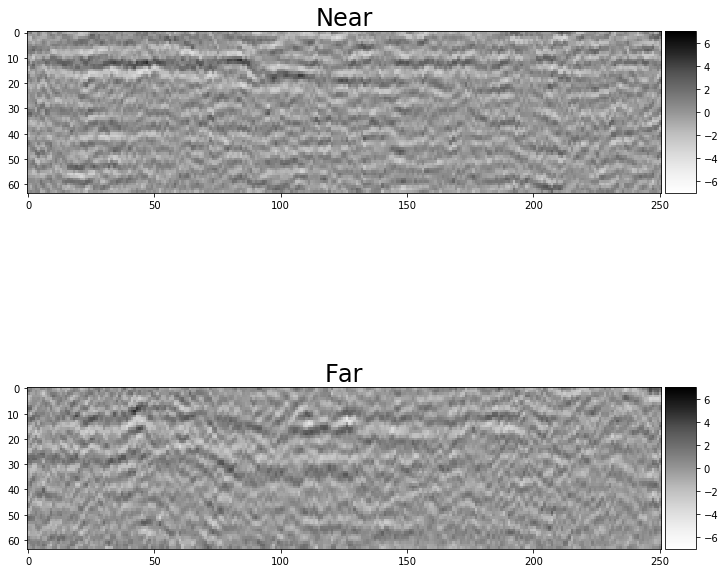

In [21]:
#I changed this graph to plot through the well line 38 rather than line 32 as was in the original
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax1 = ax[0].imshow(near_traces[well_i].T, cmap="Greys", vmin=-7, vmax=7)
colorbar(ax1)
ax2 = ax[1].imshow(far_traces[well_i].T, cmap="Greys", vmin=-7, vmax=7)
colorbar(ax2)
ax[0].set_title("Near", fontsize=24)
ax[1].set_title("Far", fontsize=24)

### Stacking the near and far offset data

The unsupervised dimensionality reduction method we will use, UMAP, treats each sample within a trace, near or far offset, as an independent variable. Therefore we simply concatenate the two traces to a stacked trace.  
Not to confuse this with _seismic stacking_, the first 64 variables will correspond to the 64 samples of our far offset trace, the second set of 64 variables will correspond to the 64 samples of the near offset trace.  

In [22]:
stacked = np.concatenate([far_traces_emb, near_traces_emb], 1)
print(stacked.shape)

(25351, 128)


### Computing a crude approximation to the fluid factor

We will use here a crude approximation to the fluid factor by computing

$$y_{avo} = \alpha*x_{avo}$$
$$f_{fluid} = y_{avo}-\alpha*x_{avo}$$

where 
- $x_{avo}$ corresponds to a near offset sample amplitude
- $y_{avo}$ corresponds to the difference between the far offset sample amplitude and the near offset amplitude

Hence the fluid factor $f_{fluid}$ is a per sample property and we can later plot it for each of our datapoints.

In [23]:
x_avo = near_traces_emb
y_avo = far_traces_emb-near_traces_emb

### Performing a linear regression on $y_{avo}$ and $x_{avo}$

In [24]:
lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

### Plotting the regression line and every 100th data point within the whole dataset

In [25]:
df = pd.DataFrame.from_items([('x', x_avo.flatten()), ('y',  y_avo.flatten())])
line_df = pd.DataFrame.from_items([('x', np.linspace(-10, 10, 100).flatten()), ('y', np.linspace(-10, 10, 100).flatten()*lin_reg.coef_[0, 0])])
line_df.head()
def image_callback(x_range, y_range, w, h, name=None):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count())
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.50, name=name)

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-7, 7), y_range=(-7, 7), plot_width=500, plot_height=500)
p.line(x='x', y='y',source=line_df, color='black',line_color=None)
InteractiveImage(p, image_callback)

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  from ipykernel import kernelapp as app


Loading BokehJS ...

### Computing the fluid factor as described above

In [26]:
print(lin_reg.coef_, lin_reg.intercept_)
FF = y_avo-lin_reg.coef_*x_avo

[[-0.89724179]] 0.0


### Plotting every amplitude sample and it's corresponding fluid factor value
Strong negative values should be indicative of hydrocarbon presence (fluid modification)

In [50]:
df = pd.DataFrame.from_items([('x', x_avo.flatten()), ('y',  y_avo.flatten()), ('FF', FF.flatten())])
line_df = pd.DataFrame.from_items([('x', np.linspace(-10, 10, 100).flatten()), ('y', np.linspace(-10, 10, 100).flatten()*lin_reg.coef_[0, 0])])
line_df.head()
def image_callback(x_range, y_range, w, h, name=None):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.min('FF'))
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.50, name=name)

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-7, 7), y_range=(-7, 7), plot_width=500, plot_height=500)
p.line(x='x', y='y',source=line_df, color='black',line_color=None)
InteractiveImage(p, image_callback)

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  from ipykernel import kernelapp as app


Loading BokehJS ...

### Plotting the fluid factor in reservoir top down view

We see here an anomaly in the fluid factor that may correspond to the features observed in the real field 
and in the case study presented in Per's book.  

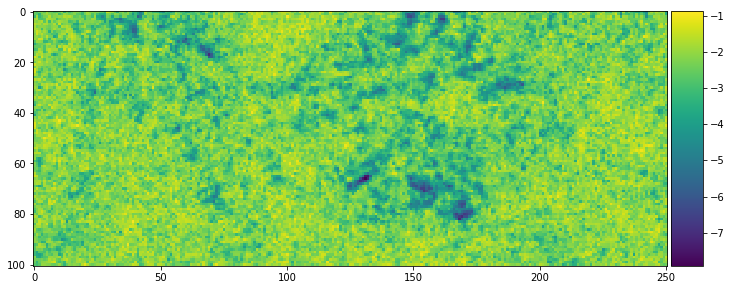

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2))
colorbar(sc)

### Performing dimensionality reduction using UMAP

We use the UMAP algorithm ([arXiv-paper](https://arxiv.org/abs/1802.03426)) to perform dimensionality reduction on the stacked near and far offset traces. Each datapoint that is reduced in dimensionality will be represented as a 2-D plane. 

Therefore we perform a mapping of:
$$\mathbf{R}^{128}\Rightarrow\mathbf{R}^2$$

From the description of UMAP on their github repo:

"Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data  

- The data is uniformly distributed on a Riemannian manifold;
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.  


From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure."

In [52]:
embedding_stack_ff = umap.UMAP(n_neighbors=50,
                      min_dist=0.001,
                      metric='correlation', verbose=True).fit_transform(np.concatenate([stacked, FF.reshape(-1, 64)], 1))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


### Plotting the dimensionality reduced data and the minimum fluid factor

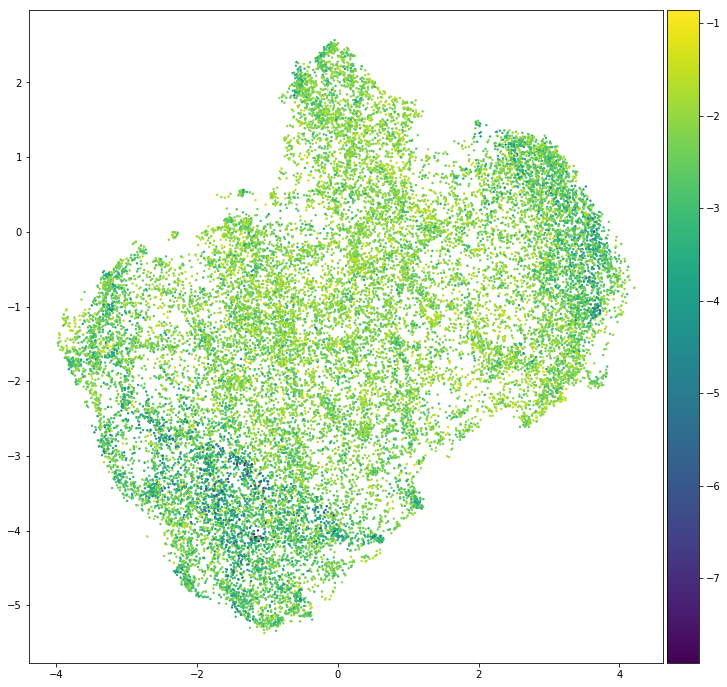

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding_stack_ff[::, 0], embedding_stack_ff[::, 1], s=2.0, c=np.min(FF, 1)[::])
colorbar(sc)
#fig.savefig("embedding_near_and_far_and_ff.png", dpi=300, bbox_inches="tight")

### Clustering of dimensionality reduced data

Here we perform a manual clustering of the data by choosing a part of the 2D data domain where we have found very low fluid factors to cluster together.  

We select this data as a binary indicator and call this our _reservoir indicator_.

The bounds we use here are:
$$ y_{umap} < -2$$
$$ x_{umap} < 0.5$$

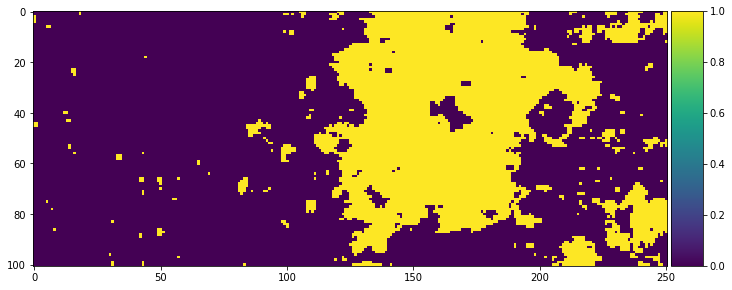

In [54]:
res_indicator = np.zeros((25351, 1))
res_indicator[np.where((embedding_stack_ff[:, 1]<-2) & (embedding_stack_ff[:, 0]<0.5))] = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax1 = ax.imshow(res_indicator.reshape(near_traces.shape[0], near_traces.shape[1]))
colorbar(ax1)

### Plotting the reservoir indicator and the horizon as contour lines

The following graphs were ultimately output for the presentation and used to represent the presence of the avo anomaly by taking into consideration the traditional fluid factor calculation.  

We can observe that the clustered anomaly seems to correspond well with the structural high, possibly delineating the _oil water contact_

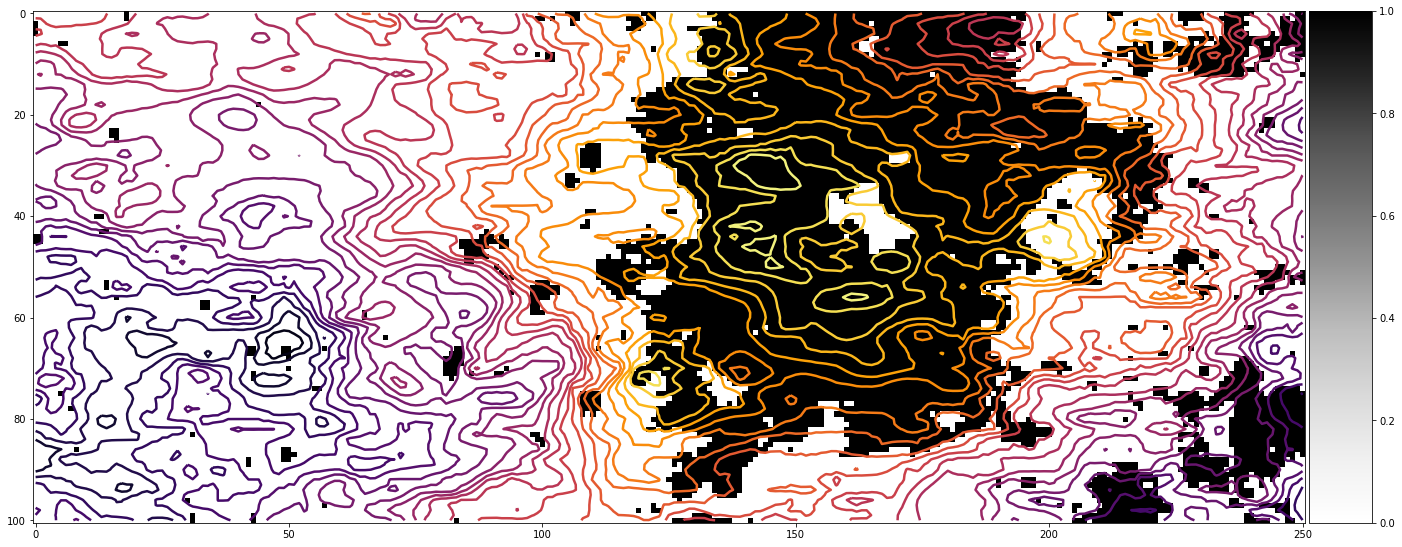

In [56]:
X, Y = np.meshgrid(np.arange(0, interpolated_horizon.shape[1]), np.arange(0, interpolated_horizon.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
c1 = ax.contour(X, Y, interpolated_horizon, alpha=1.0, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 25), linewidths=2.5, cmap="inferno_r")
sc = ax.imshow(res_indicator.reshape(near_traces.shape[0], near_traces.shape[1]), cmap="Greys")
colorbar(sc)
#fig.savefig("top_structure_and_binary_fluid_class.png", dpi=300, bbox_inches="tight")

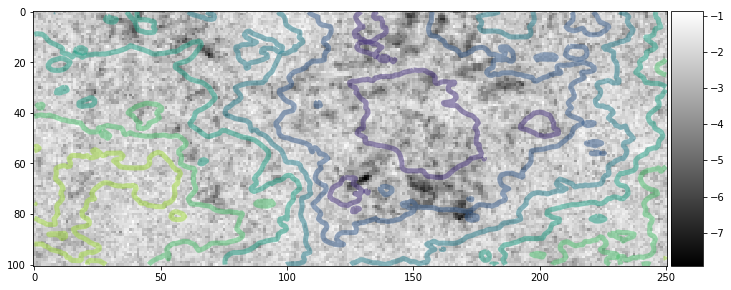

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2), cmap="gray")
c1 = ax.contour(X, Y, horizon, alpha=0.5, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 8), linewidths=5)
colorbar(sc)

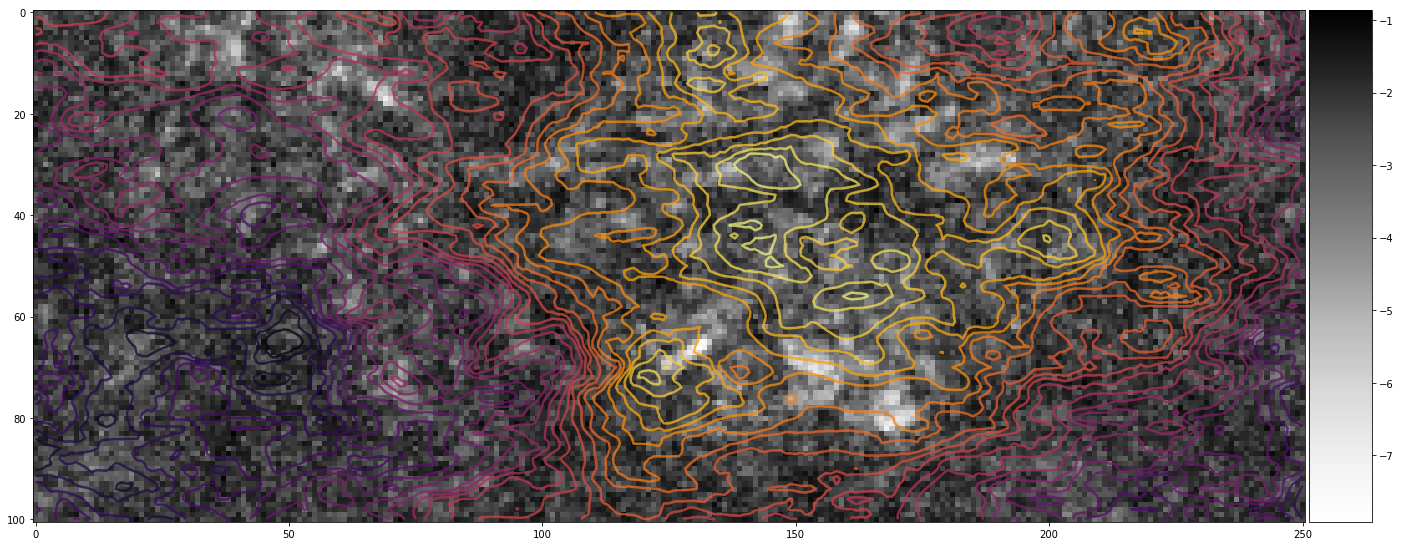

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
c1 = ax.contour(X, Y, interpolated_horizon, alpha=0.75, levels=np.linspace(interpolated_horizon.min(), interpolated_horizon.max(), 25), linewidths=2.5, cmap="inferno_r")
sc = ax.imshow(np.min(FF.reshape(near_traces.shape[0], near_traces.shape[1], 64)[:, :, :], 2), cmap="Greys")
colorbar(sc)
#fig.savefig("top_structure_and_fluid_factor.png", dpi=300, bbox_inches="tight")

In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.model_selection import ShuffleSplit

from utils import VAE, set_seed
import os
from livelossplot import PlotLosses

In [34]:
cuda = False
batch_size = 32
window_size = 64
epochs = 100
hidden_size = 2

In [35]:
near_traces = np.load("./near_traces_64.npy")
far_traces =  np.load("./far_traces_64.npy")

well_i, well_x = 38, 138
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
near_traces /= well_variance_near
far_traces /= well_variance_far

print(near_traces.min(), near_traces.max())
print(far_traces.min(), far_traces.max())

near_traces_emb = near_traces.reshape(-1, 64)
far_traces_emb =far_traces.reshape(-1, 64)

X = torch.from_numpy(np.stack([near_traces_emb, far_traces_emb], 1)).float()
y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

split = ShuffleSplit(n_splits=1, test_size=0.8)
for train_index, test_index in split.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

train_dset = TensorDataset(X_train, y_train)
test_dset = TensorDataset(X_test, y_test)
all_dset = TensorDataset(X, y)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)

-5.895588494848423 6.0386670251870616
-7.854934933402996 6.753585219701001


In [36]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, window_size=64):
    criterion_mse = nn.MSELoss(size_average=False)
    MSE = criterion_mse(recon_x.view(-1, 2, window_size), x.view(-1, 2, window_size))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [37]:
def train(epoch, model, optimizer, train_loader, cuda=False, log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test(epoch, model, test_loader, cuda=False, log_interval=10):
    model.eval()
    test_loss = 0
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(test_loader):
                if cuda:
                    data = data.cuda()
                data = Variable(data)
                recon_batch, mu, logvar, _ = model(data)
                test_loss += loss_function(recon_batch, data, mu, logvar).item()

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

def forward_all(model, all_loader, cuda=False):
    model.eval()
    reconstructions, latents = [], []
    with torch.set_grad_enabled(False):
        for i, (data, _) in enumerate(all_loader):
                if cuda:
                    data = data.cuda()
                data = Variable(data)
                recon_batch, mu, logvar, z = model(data)
                reconstructions.append(recon_batch.cpu())
                latents.append(z.cpu())
    return torch.cat(reconstructions, 0), torch.cat(latents, 0)

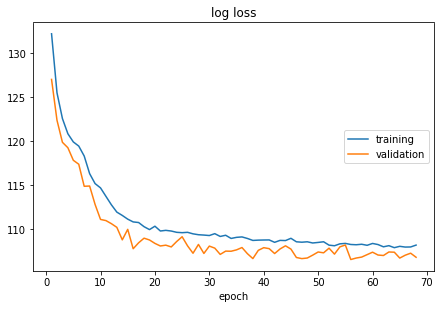

log loss:
training   (min:  107.852, max:  132.220, cur:  108.146)
validation (min:  106.502, max:  127.020, cur:  106.758)
Train Epoch: 69 [0/5070 (0%)]	Loss: 114.605293
Train Epoch: 69 [320/5070 (6%)]	Loss: 98.170097
Train Epoch: 69 [640/5070 (13%)]	Loss: 117.465347
Train Epoch: 69 [960/5070 (19%)]	Loss: 100.504395


KeyboardInterrupt: 

In [38]:
from utils import VAE
set_seed(42)
model = VAE(hidden_size=8)
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

losses = []
liveloss = PlotLosses()
min_loss = 999.
for epoch in range(1, epochs + 1):
    logs = {}
    tl = train(epoch, model, optimizer, train_loader)
    logs['' + 'log loss'] = tl
    
    testl = test(epoch, model, test_loader)
    logs['val_' + 'log loss'] = testl
    
    if epoch == epochs:
        sample = Variable(torch.randn(64, hidden_size))
        if cuda:
            sample = sample.cuda()
        sample = model.decode(sample).cpu()
    losses.append([tl, testl])
    liveloss.update(logs)
    liveloss.draw()
    if testl < min_loss:
        torch.save(model.state_dict(), "./models/model_epoch_"+str(epoch)+".pth")
        min_loss = testl

In [39]:
model.load_state_dict(torch.load("./models/model_epoch_56.pth"))

In [40]:
rec, zs = forward_all(model, all_loader)

In [41]:
print(rec.size(), zs.size())

torch.Size([25351, 2, 64]) torch.Size([25351, 8])


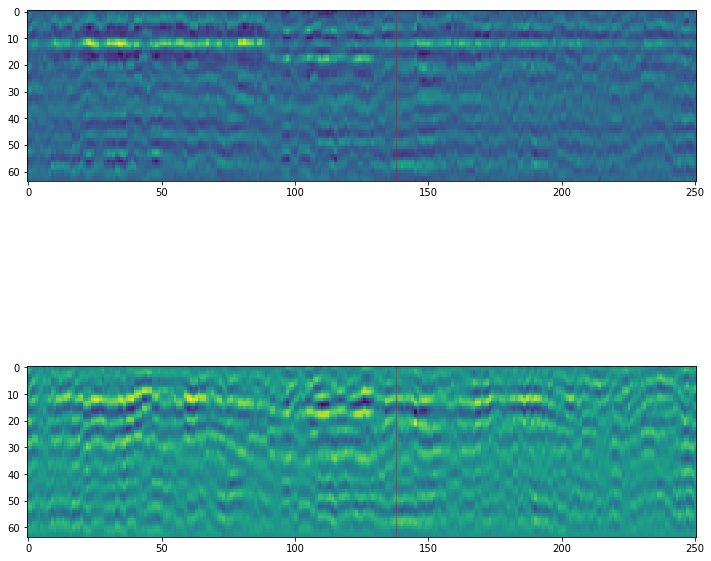

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(rec.reshape(101, 251, 2, 64)[38, :, 0, :].numpy().T)
ax[1].imshow(rec.reshape(101, 251, 2, 64)[38, :, 1, :].numpy().T)
ax[0].axvline(138, color="red", alpha=0.5, linewidth=1)
ax[1].axvline(138, color="red", alpha=0.5, linewidth=1)

In [43]:
near_sampled = rec.reshape(101, 251, 2, 64)[:, :, 0, :].numpy()
far_sampled = rec.reshape(101, 251, 2, 64)[:, :, 1, :].numpy()

Text(0.5, 1.0, 'Far Offset')

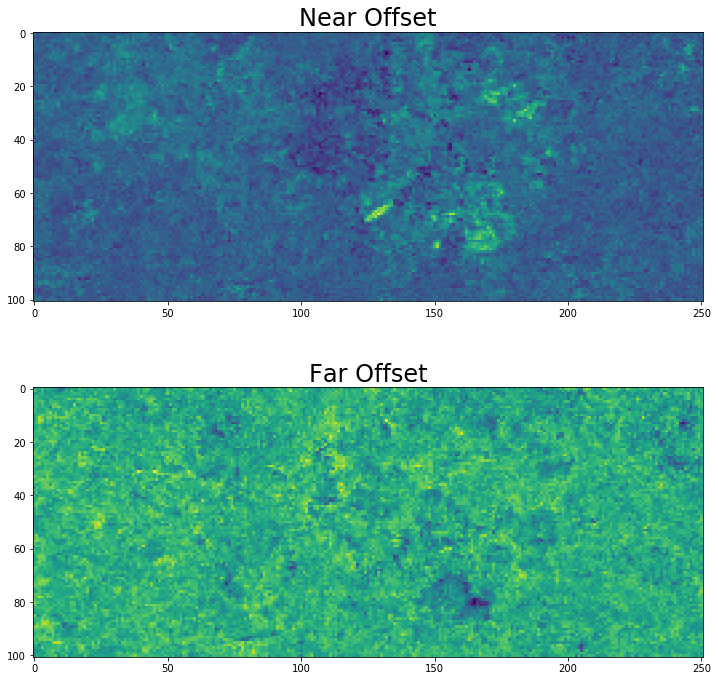

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(np.mean(near_sampled, 2))
sc = ax[1].imshow(np.mean(far_sampled, 2))
ax[0].set_title("Near Offset", fontsize=24)
ax[1].set_title("Far Offset", fontsize=24)

Text(0.5, 1.0, 'Far Offset')

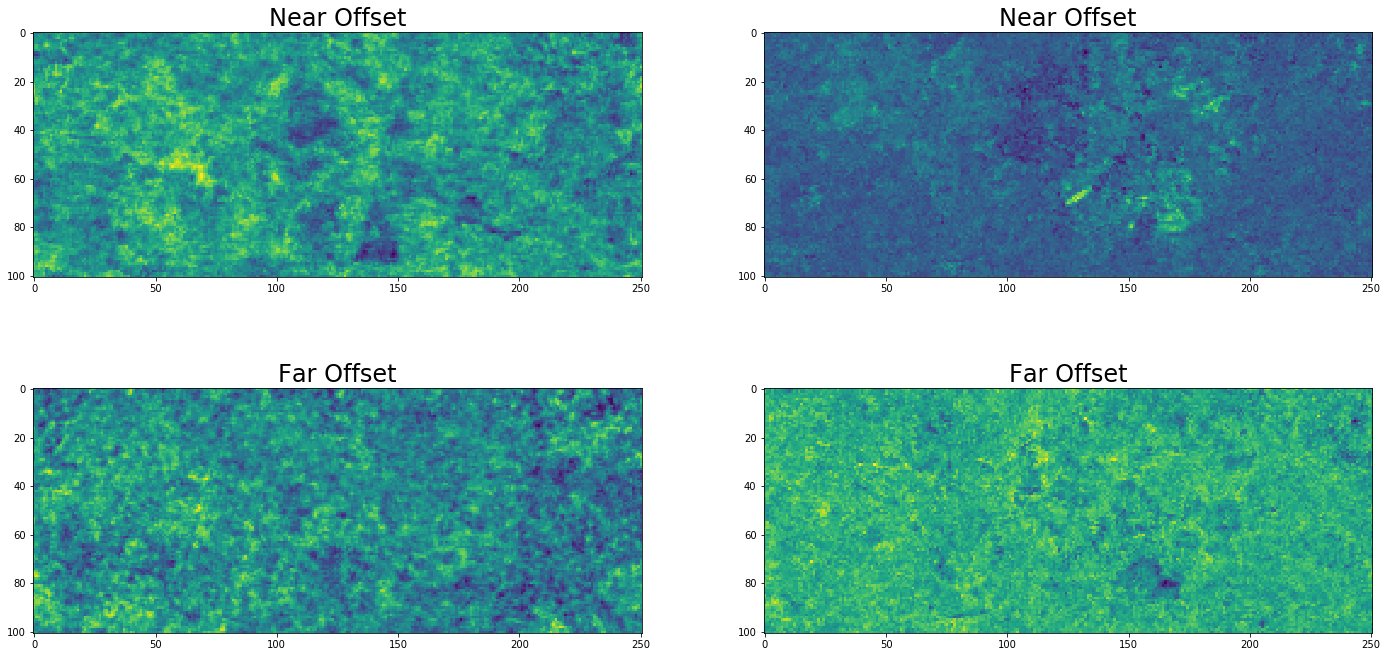

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12))
ax[0, 1].imshow(np.mean(near_sampled, 2))#, vmin=vmin, vmax=vmax)
sc = ax[1, 1].imshow(np.mean(far_sampled, 2))#, vmin=vmin, vmax=vmax)
ax[0, 1].set_title("Near Offset", fontsize=24)
ax[1, 1].set_title("Far Offset", fontsize=24)

ax[0, 0].imshow(np.mean(near_traces, 2))#, vmin=vmin, vmax=vmax)
sc = ax[1, 0].imshow(np.mean(far_traces, 2))#, vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Near Offset", fontsize=24)
ax[1, 0].set_title("Far Offset", fontsize=24)

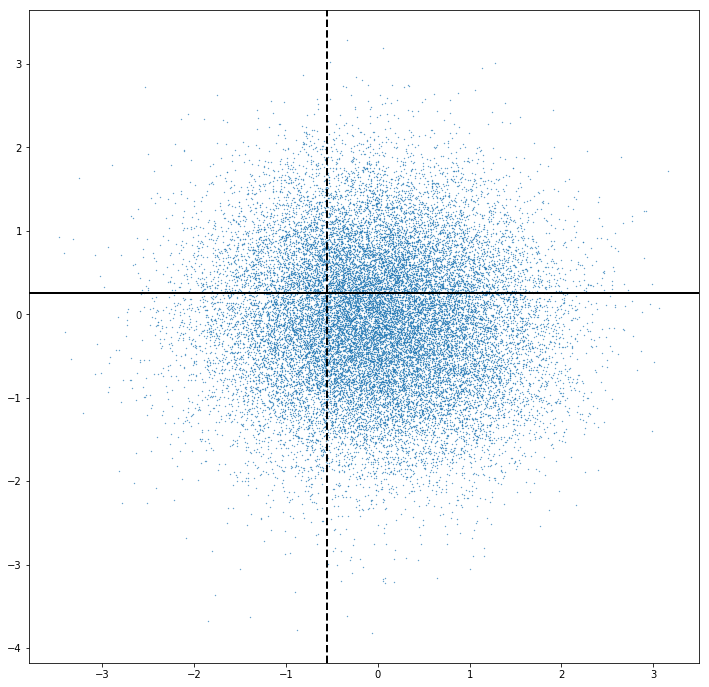

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(zs[:, 0], zs[:, 1], s=0.1)#, c=np.min(FF, 2).reshape(-1))
#fig.colorbar(sc)
ax.axvline(-0.55, color="black", linestyle="--", linewidth=2)
ax.axhline(0.25, linestyle="-", color="black", linewidth=2)
#fig.savefig("unsupervised_encoder_space.png", dpi=300, bbox_inches="tight")

In [72]:
transformer = umap.UMAP(n_neighbors=5,
                      min_dist=0.001,
                      metric='correlation', verbose=True).fit(zs.numpy())
embedding = transformer.transform(zs.numpy())

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


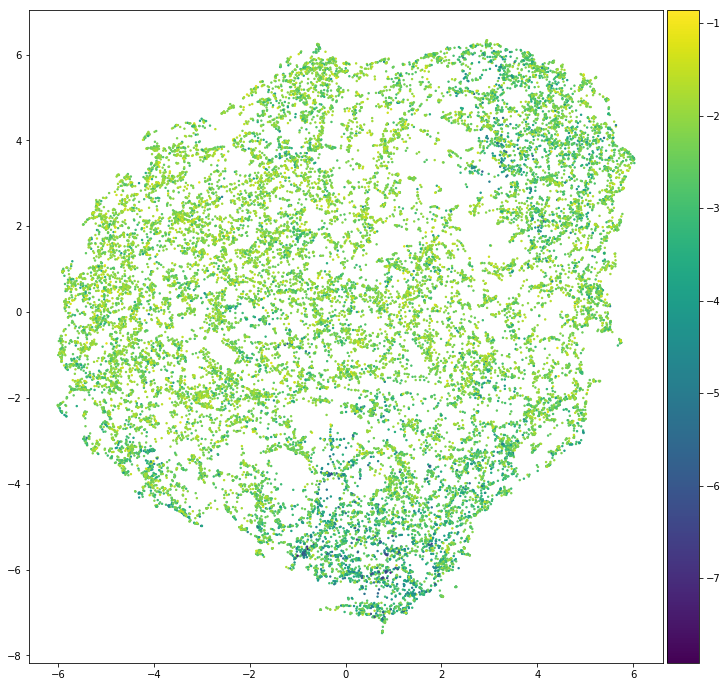

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding[::, 0], embedding[::, 1], s=2.0, c=np.min(FF, 1)[::])
colorbar(sc)

In [51]:
r = np.sqrt(embedding[:, 0]**2+embedding[:, 1]**2)
print(r.shape)

(25351,)


(101, 251)


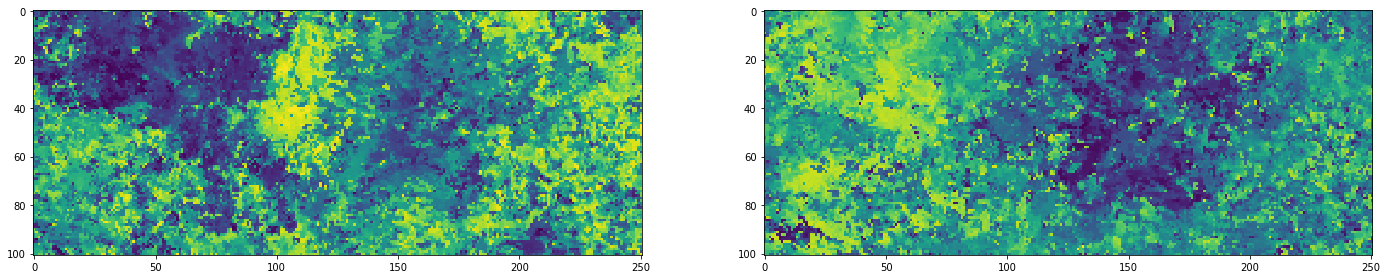

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(24, 24))
r_res = r.reshape(101, 251)
print(r_res.shape)
ax[0].imshow(embedding[:, 0].reshape(101, 251))
ax[1].imshow(embedding[:, 1].reshape(101, 251))

In [62]:
synthetics = pd.read_csv("./megasynt.csv")
synthetics['WELL']=synthetics['WELL'].astype('category')
synthetics['ID']=synthetics['ID'].astype('category')
synthetics.head()

TWT        DEPTH           VP           VS       RHO          NEAR  \
0  2.568  2100.822816  2429.415852  1018.341144  2.255582 -1.215363e-10   
1  2.572  2105.563679  2429.415852  1018.341144  2.255582 -3.881229e-09   
2  2.576  2110.183740  2429.415852  1018.341144  2.255582 -9.194981e-08   
3  2.580  2114.912341  2429.415852  1018.341144  2.255582 -1.611343e-06   
4  2.584  2119.814871  2429.415852  1018.341144  2.255582 -2.080550e-05   

            FAR    WELL               ID  
0 -8.058615e-11  W155_5  Z40_Sw025_Por20  
1 -2.573498e-09  W155_5  Z40_Sw025_Por20  
2 -6.096849e-08  W155_5  Z40_Sw025_Por20  
3 -1.068421e-06  W155_5  Z40_Sw025_Por20  
4 -1.379535e-05  W155_5  Z40_Sw025_Por20

In [64]:
unique_names = np.unique(synthetics['ID'])
print(unique_names)

z_vals, sw_vals, por_vals = [], [], []
for max_cor in unique_names:
    splt = max_cor.split("_")
    z_val = float(splt[0][1:])
    sw_val = float(splt[1].strip("Sw"))
    por_val = float(splt[2][3:])
    #print(z_val, sw_val, por_val)
    z_vals.append(z_val)
    sw_vals.append(sw_val)
    por_vals.append(por_val)
    
print(sw_vals)

['Z00_Sw000_Por20' 'Z00_Sw000_Por25' 'Z00_Sw000_Por30' 'Z00_Sw000_Por35'
 'Z00_Sw025_Por20' 'Z00_Sw025_Por25' 'Z00_Sw025_Por30' 'Z00_Sw025_Por35'
 'Z00_Sw050_Por20' 'Z00_Sw050_Por25' 'Z00_Sw050_Por30' 'Z00_Sw050_Por35'
 'Z00_Sw075_Por20' 'Z00_Sw075_Por25' 'Z00_Sw075_Por30' 'Z00_Sw075_Por35'
 'Z00_Sw100_Por20' 'Z00_Sw100_Por25' 'Z00_Sw100_Por30' 'Z00_Sw100_Por35'
 'Z20_Sw000_Por20' 'Z20_Sw000_Por25' 'Z20_Sw000_Por30' 'Z20_Sw000_Por35'
 'Z20_Sw025_Por20' 'Z20_Sw025_Por25' 'Z20_Sw025_Por30' 'Z20_Sw025_Por35'
 'Z20_Sw050_Por20' 'Z20_Sw050_Por25' 'Z20_Sw050_Por30' 'Z20_Sw050_Por35'
 'Z20_Sw075_Por20' 'Z20_Sw075_Por25' 'Z20_Sw075_Por30' 'Z20_Sw075_Por35'
 'Z20_Sw100_Por20' 'Z20_Sw100_Por25' 'Z20_Sw100_Por30' 'Z20_Sw100_Por35'
 'Z40_Sw000_Por20' 'Z40_Sw000_Por25' 'Z40_Sw000_Por30' 'Z40_Sw000_Por35'
 'Z40_Sw025_Por20' 'Z40_Sw025_Por25' 'Z40_Sw025_Por30' 'Z40_Sw025_Por35'
 'Z40_Sw050_Por20' 'Z40_Sw050_Por25' 'Z40_Sw050_Por30' 'Z40_Sw050_Por35'
 'Z40_Sw075_Por20' 'Z40_Sw075_Por25' 'Z40_Sw075_Por

In [65]:
synthetics_well = []
for name in unique_names:
    well = synthetics.loc[synthetics['ID'] == name]
    synthetics_well.append([well['NEAR'], well['FAR']])
synthetics_well = np.array(synthetics_well)

In [104]:
pseudos = synthetics_well

well_i, well_x = 38, 138
well_variance_near = np.mean(np.std(near_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))
well_variance_far = np.mean(np.std(far_traces[well_i-2:well_i+1, well_x-2:well_x+1], 2))

well_trace_near = near_traces[well_i, well_x]
well_trace_far = far_traces[well_i, well_x]

well_trace_near_abs_std = np.std(np.abs(well_trace_near))
well_trace_far_abs_std = np.std(np.abs(well_trace_far))

print("1", well_trace_near_abs_std/pseudos[:, 0, :].std(), well_variance_near)
print("2", well_trace_far_abs_std/pseudos[:, 1, :].std(), well_variance_far)

pseudos[:, 0, :] = pseudos[:, 0, :]*well_trace_near_abs_std/ pseudos[:, 0, :].std()
pseudos[:, 1, :] = pseudos[:, 1, :]*well_trace_far_abs_std/pseudos[:, 1, :].std()

near_traces /= well_variance_near
far_traces /= well_variance_far

pseudos[:, 0, :] /= well_variance_near
pseudos[:, 1, :] /= well_variance_far

amplitude_factor = 3.
X = torch.from_numpy(np.stack([pseudos[:, 0, :], pseudos[:, 1, :]], 1)).float()*amplitude_factor
y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

pseudo_dset = TensorDataset(X, y)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

pseudo_loader = torch.utils.data.DataLoader(pseudo_dset, batch_size=batch_size, shuffle=False, **kwargs)

1 1.0 1.0
2 1.0 1.0


In [105]:
recs_pseudo, zs_pseudo = forward_all(model, pseudo_loader)

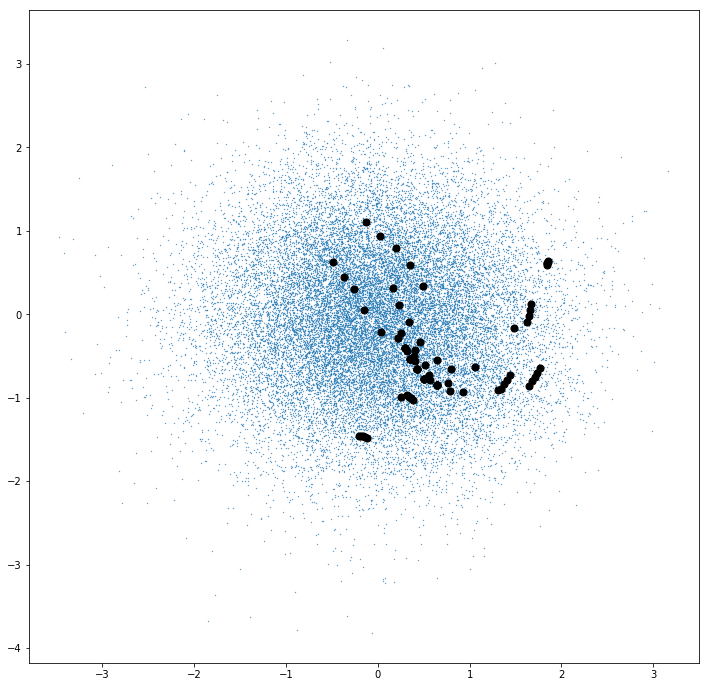

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(zs[:, 0], zs[:, 1], s=0.1)
ax.scatter(zs_pseudo[:, 0], zs_pseudo[:, 1], s=50, color="black")
#fig.savefig("unsupervised_encoder_space_with_superstack.png", dpi=300, bbox_inches="tight")

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


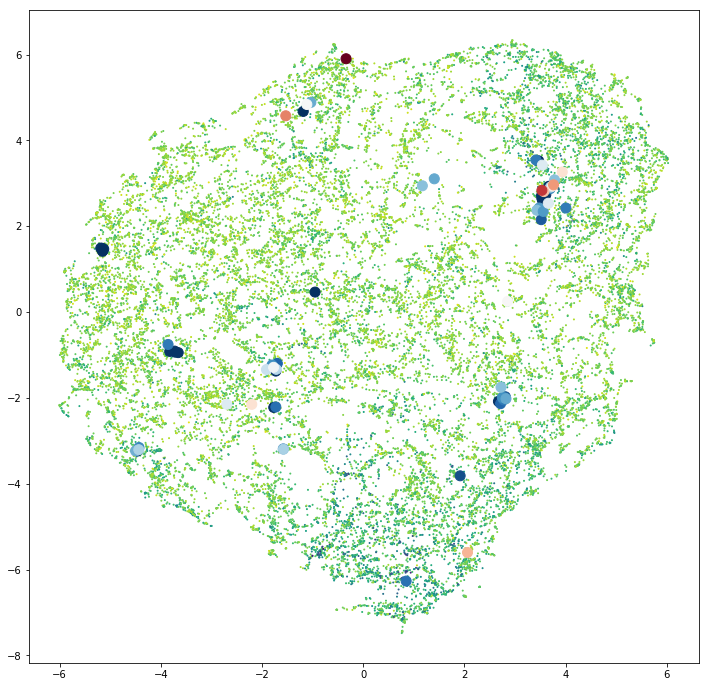

In [107]:
pseudo_umap = transformer.transform(zs_pseudo.numpy())
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(embedding[:, 0], embedding[:, 1], s=1.0, c=np.min(FF, 1))
ax.scatter(pseudo_umap[:, 0], pseudo_umap[:, 1], s=100.0, c=np.array(z_vals)*np.array(por_vals)*(1.-np.array(sw_vals)), cmap="RdBu")